In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from geopack import geopack
import sys
import pandas as pd
import seaborn as sns
import xarray as xr
import datetime as datetime

#sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
sys.path.append('/home/sachin/miniconda3/envs/server_env')
from esn_dts_openloop_SR import ESN, Tikhonov

Load IGRF coefficients ...


In [2]:
#REPPU otuputs
#path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Data/pwbig5min.dat'#Mac
#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/pbig5min.dat' #Server

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

In [3]:
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [4]:
# Reshape the array to have dimensions (days, time (5-min intervals), lat, lon)
#288 will become 1440 at 1-min resolution in SMRAI v3.0
data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
                coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['potential'].attrs['units'] = 'kV'
ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset>
Dimensions:    (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 2021-05-10 ... 2022-07-31T23:55:00
  * lat        (lat) float64 53.1 54.36 55.62 56.89 ... 85.91 87.18 88.44 89.7
  * lon        (lon) float64 1.6 6.106 10.61 15.12 ... 344.1 348.6 353.1 357.6
Data variables:
    potential  (dt, lat, lon) float32 0.6909 0.507 0.3146 ... -22.67 -22.71

In [5]:
#open the omni data and merge it with the REPPU data
#omni_mhd_path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/data/omni/'
omni_mhd_path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/OMNI/'

#omni_df = pd.read_csv('omni_mhd_5min.csv')
omni_df = pd.read_csv('omni_add-feats_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.dropna()

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='inner')
reppu_omni_ds.sortby('dt')

reppu_omni_ds = reppu_omni_ds.drop(['T', 'E', 'doy','BSN_x','SYM_H','F10.7','Kp','Mach_num'])
reppu_omni_ds = reppu_omni_ds.drop(['flow_speed','proton_density'])
reppu_omni_ds

<xarray.Dataset>
Dimensions:     (dt: 42158, lat: 30, lon: 80)
Coordinates:
  * dt          (dt) datetime64[ns] 2021-05-10 ... 2022-07-31T23:55:00
  * lat         (lat) float64 53.1 54.36 55.62 56.89 ... 85.91 87.18 88.44 89.7
  * lon         (lon) float64 1.6 6.106 10.61 15.12 ... 344.1 348.6 353.1 357.6
Data variables:
    potential   (dt, lat, lon) float32 0.6909 0.507 0.3146 ... -22.67 -22.71
    BY_GSE      (dt) float64 4.72 4.35 4.61 4.65 ... -9.29 -8.77 -9.31 -8.22
    BZ_GSE      (dt) float64 6.24 6.55 6.56 6.89 ... -0.53 -0.74 -4.03 -4.71
    Pressure    (dt) float64 2.87 2.72 3.02 3.0 2.97 ... 2.79 3.33 3.06 3.13
    tilt_angle  (dt) float64 0.253 0.2497 0.2465 0.2433 ... 0.2778 0.2744 0.271

Slices for 1-min

In [6]:
# Define the slice ranges for train and test data
train_slice = slice(0, 182880)  #182880 / 24 hr / 60 min = 127 days = 80% of the data
test_slice = slice(182880, None)  # 46080 / 24 hr / 60 min = 32 days = 20% of the data

# Create ds_train and ds_test datasets
ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

Slices for 5-mins

In [7]:
# Define the slice ranges for train and test data
train_slice = slice(0, 36576)  #36576 / 24 / 12 = 127 days = 80% of the data
test_slice = slice(36576, None)  # 9216 / 24 / 12 = 32 days = 20% of the data

#train_slice = slice(0, 38880)  #38880 / 24 / 12 = 135 days = 85% of the data
#test_slice = slice(38880, None)  # 6192 / 24 / 12 = 24 days = 15% of the data

# Create ds_train and ds_test datasets
ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

In [8]:
#training data
X_train = ds_train.drop_vars('potential').to_array().values.T
y_train = ds_train['potential'].values
y_train = y_train.reshape(-1, 30*80) #flatten lat & lon

#test data
X_test = ds_test.drop_vars('potential').to_array().values.T
y_test = ds_test['potential'].values
y_test = y_test.reshape(-1, 30*80) #flatten lat & lon

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36576, 4), (36576, 2400), (5582, 4), (5582, 2400))

Initial Parameters

In [10]:
'''
input_dim = X_train.shape[1] #number of input features
output_dim = y_train.shape[1] #number of output features
reservoir_size = 250 #number of reservoir neurons
density = 0.1 #connection density
input_scaling = 0.1 #scaling of input weights
spectral_radius = 0.99 #spectral radius of the recurrent matrix
beta = 1e-3 #regularization factor
'''

'\ninput_dim = X_train.shape[1] #number of input features\noutput_dim = y_train.shape[1] #number of output features\nreservoir_size = 250 #number of reservoir neurons\ndensity = 0.1 #connection density\ninput_scaling = 0.1 #scaling of input weights\nspectral_radius = 0.99 #spectral radius of the recurrent matrix\nbeta = 1e-3 #regularization factor\n'

Optimised Hyperparameters

In [11]:
input_dim = X_train.shape[1] #number of input features
output_dim = y_train.shape[1] #number of output features
reservoir_size = 450 #number of reservoir neurons
density = 0.2 #connection density
input_scaling = 0.1 #scaling of input weights
spectral_radius = 0.99 #spectral radius of the recurrent matrix
beta = 1e-2 #regularization factor

In [12]:
model = ESN(input_dim, output_dim, reservoir_size, density, input_scaling, spectral_radius)
optimizer = Tikhonov(input_dim, reservoir_size, output_dim, beta=beta)
model.train(X_train, y_train, optimizer)

Training progress: 0.00%
Training progress: 0.27%
Training progress: 0.55%
Training progress: 0.82%
Training progress: 1.09%
Training progress: 1.37%
Training progress: 1.64%
Training progress: 1.91%
Training progress: 2.19%
Training progress: 2.46%
Training progress: 2.73%
Training progress: 3.01%
Training progress: 3.28%
Training progress: 3.55%
Training progress: 3.83%
Training progress: 4.10%
Training progress: 4.37%
Training progress: 4.65%
Training progress: 4.92%
Training progress: 5.19%
Training progress: 5.47%
Training progress: 5.74%
Training progress: 6.01%
Training progress: 6.29%
Training progress: 6.56%
Training progress: 6.84%
Training progress: 7.11%
Training progress: 7.38%
Training progress: 7.66%
Training progress: 7.93%
Training progress: 8.20%
Training progress: 8.48%
Training progress: 8.75%
Training progress: 9.02%
Training progress: 9.30%
Training progress: 9.57%
Training progress: 9.84%
Training progress: 10.12%
Training progress: 10.39%
Training progress: 10.6

array([[ 1.93396821e+00,  4.98310261e+00,  1.65607348e+01, ...,
         5.36645225e-01, -1.84960455e+01,  2.31790366e+00],
       [ 1.61076512e+01,  7.17580314e+00,  1.91945379e+01, ...,
        -7.43177200e+00, -1.51628574e+01,  3.79049365e+00],
       [ 1.87694482e+01,  8.22029048e+00,  1.48646453e+01, ...,
        -8.89979453e+00, -1.71080887e+01, -1.37547980e-02],
       ...,
       [-1.67915004e+00,  2.09954332e+01, -1.33144194e+01, ...,
        -1.21860379e+01,  5.83452624e+00, -2.18894865e+01],
       [-3.81966417e+00,  1.92227313e+01, -1.41733618e+01, ...,
        -1.24846414e+01,  7.15026138e+00, -1.87992002e+01],
       [-5.09339485e+00,  2.04498771e+01, -1.37979388e+01, ...,
        -1.08953459e+01,  8.60019731e+00, -1.88454291e+01]])

In [13]:
#save model
#with open('SMRAI2_potential_ID15.pkl', 'wb') as f:
#   pickle.dump(model, f)

#load model
#with open('SMRAI2_current_SR.pkl', 'rb') as f:
#    model = pickle.load(f)

In [14]:
#make prediction on the test data
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1, 30, 80) #reshape the prediction to lat, lon

In [15]:
ds_test['potential_pred'] = (('dt', 'lat', 'lon'), y_pred)
ds_test['potential_pred'].attrs['units'] = 'kV'
ds_test['err_abs'] = np.abs(ds_test['potential_pred'] - ds_test['potential'])
ds_test['err'] = ds_test['potential_pred'] - ds_test['potential']
ds_test['err_pct'] = ds_test['err'] / ds_test['potential'] * 100
ds_test['MLT'] = np.mod(ds_test['lon'] / 15, 24)
ds_test

<xarray.Dataset>
Dimensions:         (dt: 5582, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 2022-07-11T15:05:00 ... 2022-07-31T23...
  * lat             (lat) float64 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon             (lon) float64 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 4.476 4.058 3.608 ... -22.67 -22.71
    BY_GSE          (dt) float64 7.96 8.2 8.13 8.94 ... -9.29 -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 -3.35 -2.99 -2.57 -2.31 ... -0.74 -4.03 -4.71
    Pressure        (dt) float64 2.16 2.29 2.28 2.15 ... 2.79 3.33 3.06 3.13
    tilt_angle      (dt) float64 0.5268 0.5285 0.5301 ... 0.2778 0.2744 0.271
    potential_pred  (dt, lat, lon) float64 5.181 4.672 4.133 ... -26.41 -26.45
    err_abs         (dt, lat, lon) float64 0.7046 0.614 0.5257 ... 3.747 3.741
    err             (dt, lat, lon) float64 0.7046 0.614 0.5257 ... -3.747 -3.741
    err_pct         (dt, lat, lon) float64 15.74 15.13 14.57 ... 16.53 16.47
    MLT             (lon) float64 0.1067 0.4071 0.7075 ... 23.24 23.54 23.84

In [16]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, np.round(nan_ratio, 2)

nan_count(ds_test, 'err')

(13396800, 0.0)

In [17]:
potential = ds_test['potential'].values
potential = potential.reshape(-1, 30, 80)

pred_pot = ds_test['potential_pred'].values
pred_pot = pred_pot.reshape(-1, 30, 80)


def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill             

RMSE = np.sqrt(np.mean((potential - pred_pot)**2))
MAE = np.mean(np.abs(potential - pred_pot))
PE = skill(potential, pred_pot)
R = np.corrcoef(potential.flatten(), pred_pot.flatten())[0, 1]

print(f'RMSE: {RMSE:.1f} kV')
print(f'MAE: {MAE:.1f} kV')
print(f'R: {R:.2f}/1')
print(f'PE: {PE:.2f}/1')

RMSE: 5.2 kV
MAE: 3.6 kV
R: 0.91/1
PE: 0.78/1


In [18]:
skill(potential,pred_pot)

0.7843903120706237

In [19]:
skill(pred_pot, potential)

0.82696865594519

/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


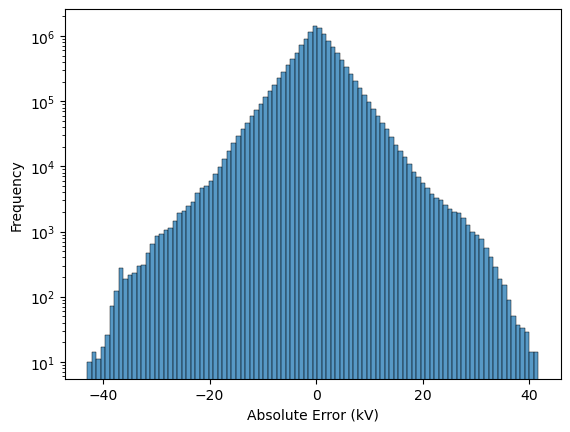

In [20]:
#plot hist of AE
sns.histplot(ds_test['err'].values.flatten(), bins=100)
plt.xlabel('Absolute Error (kV)')
plt.ylabel('Frequency')
plt.yscale('log')

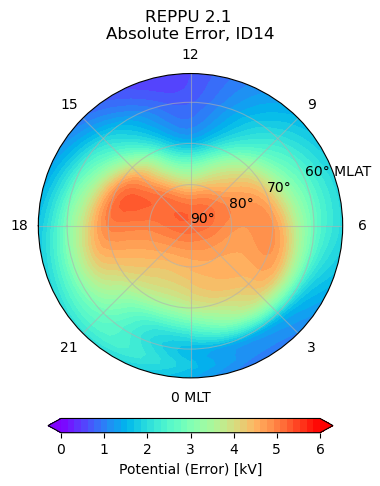

In [21]:
# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .5

# Plot true values
abs_error = np.abs(ds_test['err_abs'].mean('dt').values)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))

c_true = ax.contourf(theta_rad, r, abs_error, levels=np.linspace(0, 6, 40), cmap='rainbow', extend='both')
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
ax.set_title(f'REPPU 2.1 \nAbsolute Error, ID14')
plt.colorbar(c_true, ax=ax, label='Potential (Error) [kV]', shrink=shrink, pad=0.1, ticks=np.arange(0,7,1), orientation='horizontal')
ax.grid(True, linestyle='-', alpha=0.6)
plt.tight_layout()
#plt.savefig('REPPU2.1_AE_ID14.png', dpi=400)

In [22]:
#plot potential on 2022-07-11, integrtaed over lat and lon

#2022-07-12 is worst


#2022-07-31 is okay
#2022-07-25 is okay

#2022-07-29 is best
#2022-07-30 is best
date = '2022-07-31'

#date_range = pd.date_range('2022-07-29', '2022-07-30', freq = 'm')

#extract SYM-H values
symh = ds_pred['Kp'].sel(dt=date)

symh_hourly = pd.DataFrame(symh.values, columns=['Kp'])
symh_hourly['dt'] = symh['dt'].values
symh_hourly.set_index('dt', inplace=True)
symh_hourly = symh_hourly.resample('3h').mean()

fig, ax = plt.subplots(figsize=(6, 4))
ds_pred['potential'].sel(dt=date).mean(['lat', 'lon']).plot(label='SMRAI2 (Prediction)', color='#648FFF')
ds_test['potential'].sel(dt=date).mean(['lat', 'lon']).plot(label='REPPU (G. Truth)', color='#FFB000')

rmse = np.sqrt(np.mean((ds_pred['potential'].sel(dt=date).values - ds_test['potential'].sel(dt=date).values)**2))
r = np.corrcoef(ds_pred['potential'].sel(dt=date).values.flatten(), ds_test['potential'].sel(dt=date).values.flatten())[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill  

skill_val = skill(ds_pred['potential'].sel(dt=date).values, ds_test['potential'].sel(dt=date).values)


'''
i = plt.annotate(f'RMSE = {rmse:.2f} kV', xy=(0.75, 0.05), xycoords='axes fraction')
j = plt.annotate(f'R = {r:.2f}', xy=(0.75, 0.12), xycoords='axes fraction')
k = plt.annotate(f'Skill = {skill_val:.2f}', xy=(0.75, 0.19), xycoords='axes fraction')

t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
i.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
j.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))'''

annotations = [
    (f'RMSE = {rmse:.1f} kV', (0.75, 0.05)),
    (f'R = {r:.2f}', (0.75, 0.15)),
    (f'Skill = {skill_val:.2f}', (0.75, 0.25))
]

for annotation, position in annotations:
    annot = plt.annotate(annotation, xy=position, xycoords='axes fraction')
    annot.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

#add SYM-H label
#plt.annotate('Kp:', xy=(-0.04, -0.25), xycoords='axes fraction'
#            , ha='center', va='center', color='k')
#add sym_hourly values beneath the x ticks
for i, val in enumerate(symh_hourly['Kp'].values):
    plt.annotate(f'{val:.1f}', xy=((0.39+i)/8.8, -0.25), xycoords='axes fraction', ha='center', va='center')

#remove top and right spines


plt.legend()
plt.title(f'Polar Cap Potential \n{date}',pad=8)
plt.xlabel(' ')
phi = r'$\mathrm{\phi}$'
plt.ylabel(f'Potential ({phi}) [kV]')
plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/rmse.png', dpi=300)

NameError: name 'ds_pred' is not defined

In [ ]:
#loop through all dates in the test and pred dataset and calculate the RMSE then put into a df
rmse_list = []
#r_list = []
#skill_list = []
for date in ds_test['dt']:
    rmse = np.sqrt(np.mean((ds_pred['potential'].sel(dt=date).values - ds_test['potential'].sel(dt=date).values)**2))
    #r = np.corrcoef(ds_pred['potential'].sel(dt=date).values.flatten(), ds_test['potential'].sel(dt=date).values.flatten())[0, 1]
    #skill_val = skill(ds_pred['potential'].sel(dt=date).values, ds_test['potential'].sel(dt=date).values)
    rmse_list.append(rmse)
    #r_list.append(r)
    #skill_list.append(skill_val)

rmse_df = pd.DataFrame(rmse_list, columns=['RMSE'])
rmse_df['dt'] = ds_test['dt']

rmse_df['date'] = rmse_df['dt'].dt.date
rmse_df['hr'] = rmse_df['dt'].dt.hour
#rmse_df['Kp'] = ds_test['Kp'].values
rmse_df

In [ ]:
rmse_df.groupby('date').mean().sort_values(by='RMSE', ascending=True)

In [ ]:
# Define the date
date = "2022-07-29"
ind = 144

# Extract true and predicted values
pot_true = ds_test['potential'].sel(dt=date).values[ind]
pot_pred = ds_pred['potential'].sel(dt=date).values[ind]

# Calculate the difference
abs_error  = ds_pred['AE'].sel(dt=date).values[ind]
pct_error = ds_pred['Error_pct'].sel(dt=date).values[ind]

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .3

# Plot true values
c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[1].set_title(f'Predicted Potential \n (SMRAI)')
plt.colorbar(c_pred, ax=axs[1], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, abs_error, levels=np.linspace(0, 10, 50), cmap='viridis', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[2].set_title('Difference \n(True - Predicted)')
plt.colorbar(c_diff, ax=axs[2], label='Absolute Error [kV]', shrink=shrink, pad=0.1, ticks=np.arange(0, 11,2), orientation='horizontal')

plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

plt.tight_layout()
plt.show()

In [ ]:
# Define the date
date = "2022-07-31"

# Extract true and predicted values
pot_true = ds_test['potential'].sel(dt=date).values[0]
pot_pred = ds_pred['potential'].sel(dt=date).values[0]

# Calculate the difference
diff = pot_true - pot_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .3

# Plot true values
c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[1].set_title(f'Predicted Potential \n (SMRAI)')
plt.colorbar(c_pred, ax=axs[1], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-30, 30, 50), cmap='bwr', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[2].set_title('Difference \n(True - Predicted)')
plt.colorbar(c_diff, ax=axs[2], label='Difference [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

plt.tight_layout()
plt.show()


In [ ]:

# Select the date
date = "2022-07-31"

# Extract times from dt dimension info
times = ds_test.sel(dt=date)['dt'].values

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .28
pad = 0.18
t_pad = 10
phi = r"$\mathrm{\phi}$"

# Loop through each time step
for i, time in enumerate(times):
    # Extract true and predicted values for the current time
    pot_true = ds_test['potential'].sel(dt=date).values[i]
    pot_pred = ds_pred['potential'].sel(dt=date).values[i]

    # Calculate the difference
    diff = pot_true - pot_pred

    # Set up the plot
    fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

    # Plot true values
    c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
    axs[0].set_ylim([0, 30])
    axs[0].set_yticks([0, 10, 20, 30])
    axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[0].set_xlim([-np.pi, np.pi])
    axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[0].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6", "9", "Midday \n12", "15", "18"])
    axs[0].set_title(f'True Potential \n (REPPU)',pad=t_pad)
    axs[0].grid(True, alpha=0.7)
    plt.colorbar(c_true, ax=axs[0], label=f'Potential ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    # Plot predicted values
    c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
    axs[1].set_ylim([0, 30])
    axs[1].set_yticks([0, 10, 20, 30])
    axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[1].set_xlim([-np.pi, np.pi])
    axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[1].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6", "9", "Midday \n12", "15", "18"])
    axs[1].set_title('Predicted Potential \n (SMRAI)',pad=t_pad)
    axs[1].grid(True, alpha=0.7)
    plt.colorbar(c_pred, ax=axs[1], label=f'Potential ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    # Plot difference
    c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-30, 30, 50), cmap='bwr', extend='both')
    axs[2].set_ylim([0, 30])
    axs[2].set_yticks([0, 10, 20, 30])
    axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[2].set_xlim([-np.pi, np.pi])
    axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[2].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6", "9", "Midday \n12", "15", "18"])
    axs[2].set_title(f'Difference \n(True - Predicted)',pad=t_pad)
    axs[2].grid(True, alpha=0.7)
    plt.colorbar(c_diff, ax=axs[2], label=f'Difference ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    plt.subplots_adjust(wspace=-0.8)  # Adjust horizontal space between subplots

    plt.tight_layout()

    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H-%M')

    plt.annotate(f'{str_time}', xy=(-1.45, -0.7), xycoords='axes fraction', fontsize=12)

    # Save the figure with the timestamp in the title
    #plt.savefig(f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/potential_plot_{str_time}.png', dpi=300, bbox_inches='tight')
    
    # Close the figure to free up memory
    #plt.close(fig)

    break